In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px



In [2]:
data = pd.read_csv('/Users/cho/Desktop/고비어/W05_dataset.csv')

data.head()


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1


In [ ]:
# 전처리 과정 교수님이 올려주신 것 참고
df = data.copy()

# 1) 날짜형 변환
date_col = ['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate']
df[date_col] = df[date_col].apply(pd.to_datetime)  # errors='raise' 기본

# 2) 문자열형 변환 
str_col = ['Store','Brand','Classification','VendorNumber','PONumber']
df[str_col] = df[str_col].astype(str)

# 3) 리드타임/오더타임/결제리드타임 
df['LeadTime']   = (df['InvoiceDate']   - df['ReceivingDate']).dt.days.astype('Int64')
df['OrderTime']  = (df['ReceivingDate'] - df['PODate']).dt.days.astype('Int64')
df['PaymentLT']  = (df['PayDate']       - df['InvoiceDate']).dt.days.astype('Int64')

# 4) InventoryId 분해
split_cols = df['InventoryId'].str.split('_', expand=True)
df[['Split_1', 'InventoryCategory', 'Split_3']] = split_cols

# 5) 보조 컬럼 제거
df = df.drop(columns=['Split_1', 'Split_3'])

# 6) InventoryCategory 빈값/결측 제거
df1 = df[df['InventoryCategory'].notna() & (df['InventoryCategory'] != '')].copy()

# 7) 피처 타입 목록
numerical_features  = df1.select_dtypes(include=[float, int, 'Int64']).columns.to_list()
date_features       = df1.select_dtypes(include=['datetime']).columns.to_list()
categorical_features = df1.columns.difference(numerical_features + date_features).to_list()

print(numerical_features)
print(date_features)
print(categorical_features)


['PurchasePrice', 'Quantity', 'Dollars', 'LeadTime', 'OrderTime', 'PaymentLT']
['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate']
['Brand', 'Classification', 'Description', 'InventoryCategory', 'InventoryId', 'PONumber', 'Size', 'Store', 'VendorName', 'VendorNumber']


EDA

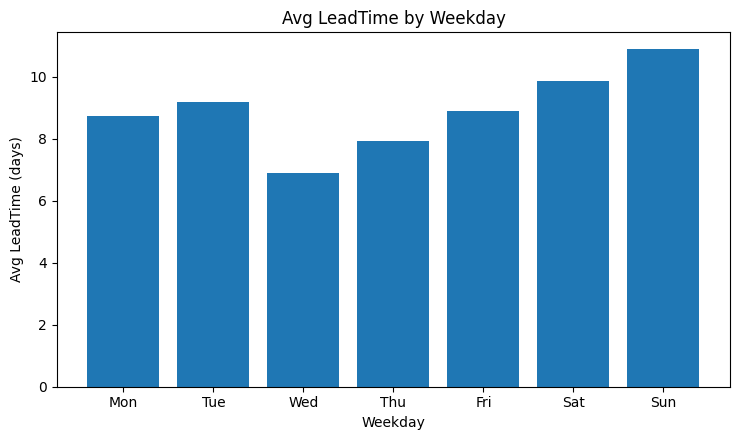

In [ ]:
# 요일별 리드타임

# 날짜/필드 안전 체크
if 'InvoiceDate' not in dfv.columns or 'LeadTime' not in dfv.columns:
    raise ValueError("InvoiceDate와 LeadTime 컬럼이 필요합니다.")

dfv['InvoiceDate'] = pd.to_datetime(dfv['InvoiceDate'], errors='coerce')
dfv['LeadTime'] = pd.to_numeric(dfv['LeadTime'], errors='coerce')

# 요일(0=Mon~6=Sun) 파생
dfv['InvoiceDOW'] = dfv['InvoiceDate'].dt.dayofweek
dow_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# 요일별 평균 리드타임
g = (
    dfv.loc[dfv['LeadTime'].notna() & dfv['InvoiceDOW'].notna(), ['InvoiceDOW','LeadTime']]
      .groupby('InvoiceDOW')['LeadTime']
      .mean()
      .reindex(range(7))           
)

# 막대그래프
plt.figure(figsize=(7.5,4.5))
plt.bar(range(7), g.values)     
plt.xticks(range(7), dow_labels)
plt.title('Avg LeadTime by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Avg LeadTime (days)')
plt.tight_layout()
plt.show()



/var/folders/r6/8msp6gqx56xbt93tkcw51j080000gn/T/ipykernel_20785/1333223374.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_by_dow, labels=dow_labels, showfliers=True)


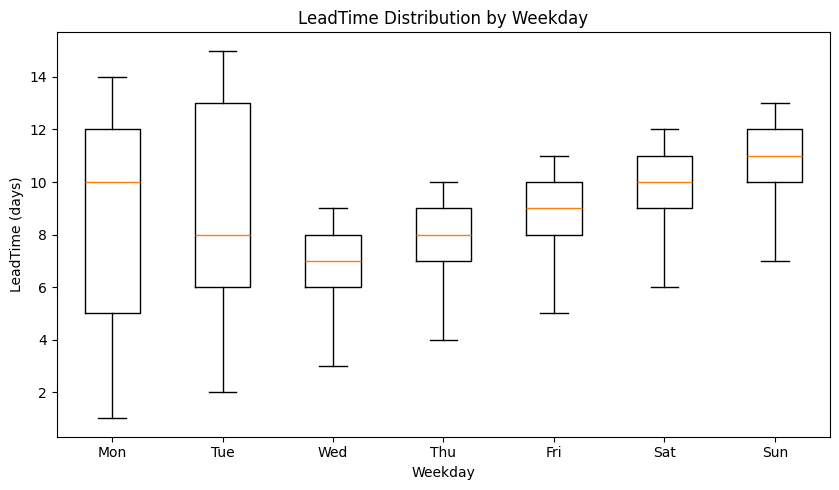

In [ ]:
# 일별 박스플랏 
fv = dfv[dfv['InvoiceDate'].notna() & dfv['LeadTime'].notna()].copy()

# 요일(0=Mon~6=Sun) 파생
dfv['InvoiceDOW'] = dfv['InvoiceDate'].dt.dayofweek
dow_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# 요일별 데이터 리스트 만들기 
data_by_dow = [dfv.loc[dfv['InvoiceDOW']==i, 'LeadTime'].astype(float).values for i in range(7)]

plt.figure(figsize=(8.5, 5))
bp = plt.boxplot(data_by_dow, labels=dow_labels, showfliers=True)

plt.title('LeadTime Distribution by Weekday')
plt.xlabel('Weekday')
plt.ylabel('LeadTime (days)')
plt.tight_layout()
plt.show()

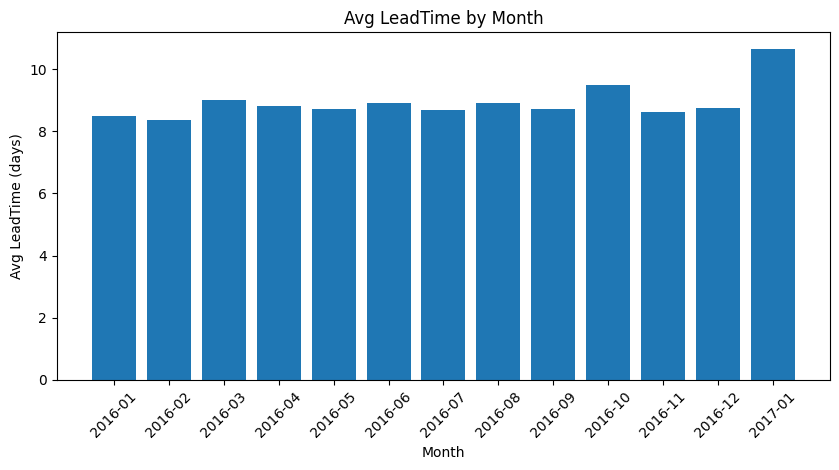

[요약] 가장 빠른 달: 2016-02 (8.4일), 가장 느린 달: 2017-01 (10.7일)


In [ ]:
# 월별 리드타임 

# 월 파생 + 월별 평균
dfv['InvoiceMonth'] = dfv['InvoiceDate'].dt.to_period('M').astype(str)
g = (dfv.loc[dfv['LeadTime'].notna() & dfv['InvoiceMonth'].notna(), ['InvoiceMonth','LeadTime']]
        .groupby('InvoiceMonth')['LeadTime'].mean()
        .sort_index())

plt.figure(figsize=(8.5,4.8))
plt.bar(range(len(g)), g.values)  # 색 지정 안 함(기본)
plt.xticks(range(len(g)), g.index, rotation=45)
plt.title('Avg LeadTime by Month')
plt.xlabel('Month')
plt.ylabel('Avg LeadTime (days)')
plt.tight_layout()
plt.show()



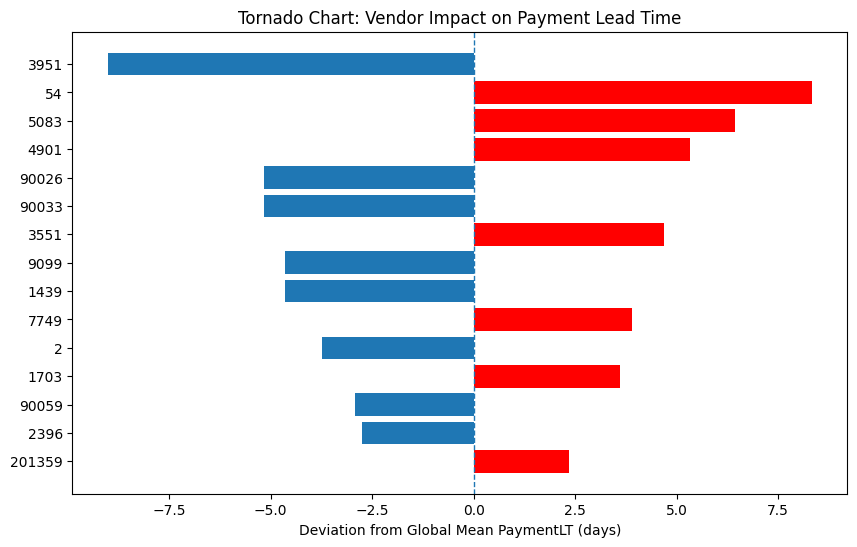

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ==== 0) 데이터 준비 (df1이 있다고 가정) ====
dfv = df1.copy()
dfv['PaymentLT'] = pd.to_numeric(dfv['PaymentLT'], errors='coerce')
dfv = dfv[dfv[['VendorNumber','PaymentLT']].notna().all(axis=1)].copy()
dfv['VendorNumber'] = dfv['VendorNumber'].astype(str)

# ==== 1) 글로벌 평균과 벤더별 편차 계산 ====
global_mean = dfv['PaymentLT'].mean()

g = (dfv.groupby('VendorNumber')['PaymentLT'].mean()
        .to_frame('mean_payment')
        .assign(diff=lambda d: d['mean_payment'] - global_mean))

# 영향도(절대편차) 큰 순서로 Top N 추림
N = 15
top = g.reindex(g['diff'].abs().sort_values(ascending=False).head(N).index)

# ==== 2) 시각화: 토네이도 차트 (+만 빨강) ====
y = np.arange(len(top))
diff = top['diff'].values

# 조건부 색상: +편차=빨강, -편차=파랑, 0=회색
colors = ['red' if v > 0 else ('0.5' if v == 0 else 'tab:blue') for v in diff]

plt.figure(figsize=(10, 6))
plt.barh(y, diff, color=colors)
plt.axvline(0, linestyle='--', linewidth=1)
plt.yticks(y, top.index)
plt.xlabel('Deviation from Global Mean PaymentLT (days)')
plt.title('Tornado Chart: Vendor Impact on Payment Lead Time')

# 보기 좋게 큰 영향이 위로 오도록
plt.gca().invert_yaxis()


In [16]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'  # 맥 기본 한글 폰트
mpl.rcParams['axes.unicode_minus'] = False   # 음수 기호 깨짐 방지


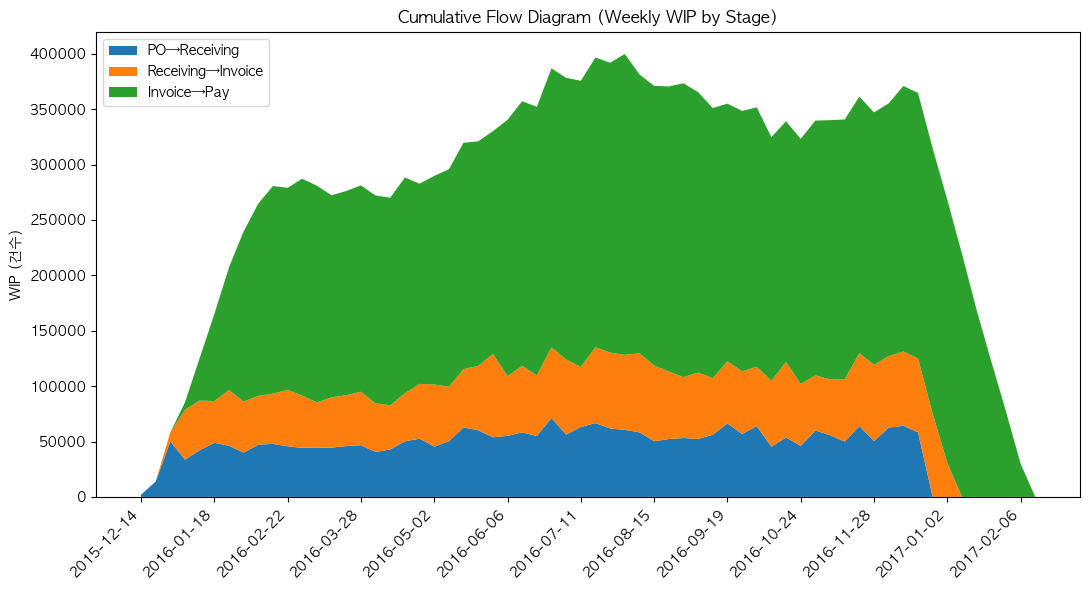

[참고] 최근 8주 단계별 WIP 변화(증가=적체):
            PO→Receiving  Receiving→Invoice  Invoice→Pay
2016-12-26      -58341.0             8346.0         94.0
2017-01-02           0.0           -44466.0      -2094.0
2017-01-09           0.0           -30610.0     -18079.0
2017-01-16           0.0                0.0     -50771.0
2017-01-23           0.0                0.0     -46359.0
2017-01-30           0.0                0.0     -45117.0
2017-02-06           0.0                0.0     -47213.0
2017-02-13           0.0                0.0     -29933.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 0) 데이터 준비 =====
dfv = df1.copy()
for c in ['PODate','ReceivingDate','InvoiceDate','PayDate']:
    dfv[c] = pd.to_datetime(dfv[c], errors='coerce')

# 유효 구간이 1개도 없으면 중단
if dfv[['PODate','ReceivingDate','InvoiceDate','PayDate']].notna().sum().sum() == 0:
    raise ValueError("유효한 날짜가 없습니다.")

# 주 시작(월)으로 스냅
def week_start(s):
    # 월요일 시작 주로 내림
    s = pd.to_datetime(s, errors='coerce')
    return s - pd.to_timedelta(s.dt.dayofweek, unit='D')

ws_PO   = week_start(dfv['PODate'])
ws_Recv = week_start(dfv['ReceivingDate'])
ws_Inv  = week_start(dfv['InvoiceDate'])
ws_Pay  = week_start(dfv['PayDate'])

t_min = pd.concat([ws_PO, ws_Recv, ws_Inv, ws_Pay]).min()
t_max = pd.concat([ws_PO, ws_Recv, ws_Inv, ws_Pay]).max()
weeks = pd.date_range(t_min, t_max, freq='W-MON')  # 월요일 시작
W = len(weeks)
if W == 0:
    raise ValueError("주차 축이 비어 있습니다.")

# ===== 1) 인덱스 매핑 함수 (searchsorted) =====
w_np = weeks.values.astype('datetime64[D]')  # np 배열로
def to_idx(col):
    m = col.notna()
    x = col[m].values.astype('datetime64[D]')
    # 해당 주(week start)가 weeks 배열에서 들어갈 위치
    idx = np.searchsorted(w_np, x, side='left')
    return m, idx

# 각 단계의 시작/끝 인덱스 계산 (끝이 NaT면 open-ended 처리)
m_PO,   s_PO   = to_idx(ws_PO)
m_Recv, s_Recv = to_idx(ws_Recv)
m_Inv,  s_Inv  = to_idx(ws_Inv)
m_Pay,  s_Pay  = to_idx(ws_Pay)

# ===== 2) 차분(difference) 배열에 일괄 반영 (np.add.at) =====
def build_wip(start_series, end_series):
    """ start_series~end_series 구간을 [start, end)로 +1 """
    diff = np.zeros(W + 1, dtype=np.int32)

    mS, s = to_idx(start_series)
    mE, e = to_idx(end_series)

    # 시작만 있고 끝 없는(open) 케이스와 정상 케이스를 나눔
    has_end = np.zeros_like(s, dtype=bool)
    e_full = np.full_like(s, W, dtype=int)  # 기본 open-ended
    e_full[mS & end_series.notna()] = np.searchsorted(
        w_np, week_start(end_series[mS & end_series.notna()]).values.astype('datetime64[D]'), side='left'
    )

    # [s, e)에 +1, e==W면 마지막까지 유지
    s_clip = np.clip(s, 0, W)
    e_clip = np.clip(e_full, 0, W)

    np.add.at(diff, s_clip, 1)
    np.add.at(diff, e_clip, -1)
    return np.cumsum(diff[:-1])

# 단계별 WIP
wip_order   = build_wip(ws_PO,   ws_Recv)  # PO → Receiving
wip_process = build_wip(ws_Recv, ws_Inv)   # Receiving → Invoice
wip_payment = build_wip(ws_Inv,  ws_Pay)   # Invoice → Pay

# ===== 3) 시각화  =====
x = np.arange(W)
plt.figure(figsize=(11,6))
plt.stackplot(x, wip_order, wip_process, wip_payment, labels=['PO→Receiving','Receiving→Invoice','Invoice→Pay'])
tick_step = max(1, W // 12)
plt.xticks(x[::tick_step], [pd.Timestamp(weeks[i]).strftime('%Y-%m-%d') for i in range(0, W, tick_step)],
           rotation=45, ha='right')
plt.ylabel('WIP (건수)')
plt.title('Cumulative Flow Diagram (Weekly WIP by Stage)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# ===== 4) 최근 8주 변화 요약  =====
po = pd.Series(wip_order,   index=weeks)
pr = pd.Series(wip_process, index=weeks)
py = pd.Series(wip_payment, index=weeks)

delta = pd.DataFrame({
    'PO→Receiving':       po.diff(),
    'Receiving→Invoice':  pr.diff(),
    'Invoice→Pay':        py.diff()
})
print(" 최근 8주 단계별 WIP 변화:")
print(delta.tail(8).round(1))
